<a href="https://colab.research.google.com/github/SERVIR/ForestStandHeight/blob/master/Section_3/PreProcess_ISCE_Kel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocess SLCs with ISCE


Now that we have installed ISCE using the [Exercise2_Install_ISCE](https://github.com/MayerT1/FSH_Python3/blob/master/Exercise2_Install_ISCE.ipynb) Colaboratory, we can preprocess our ALOS PALSAR data using this software. The overall methodology for Exercise 2 is shown below. 

![alt text](https://drive.google.com/uc?id=1B51BR6_HqHjE9YwfBbHJlmr-nFWYDdYC)

The pre-processing step in ISCE takes two Single Look Complex (SLC) images from different dates over the same location and creates a geocoded interferogram that we will later use to estimate forest stand height (FSH). 

#1. Data Acquisition

##1.1 ALOS PALSAR

For this exercise, we will be using two Single Look Complex (SLC) ALOS PALSAR images overlooking a section of Maine, US. When selecting SAR data, it is important to:

1.   use only ascending or descending pairs to create an interferogram
2.   keep in mind that dialectric differences (i.e. moisture) between the two dates will decrease the accuracy of the resulting FSH estimate
3.  the SLC pairs must overlap with ground truth FSH data or overlap with another pair that overlaps with groundtruth data (shown below)

The data used for this exercise was requested from [the Alaska Satellite Facility](https://www.asf.alaska.edu/) (ASF). Data availability from ASF. info on JAXA. sentence about NISAR.

#step 1

[01_Inputs_to_ISCE](https://drive.google.com/open?id=1aFQWGBDdjEegE-gIYza67i5Toft-Q9Ew) includes two folders: SLC_07102007 contains the SLC files for July 10, 2007 and SLC_10102007 contains the files for October 10, 2007. **Please copy this folder to your Google Drive.**

Move the folders to correct directory.

The SLCs provided by ASF are in Committee on Earth Observation Satellites, or CEOS, format. The SLC_07102007 and SLC10102007 folders each contain five files. See the ASF graphic below for descriptions of each file type. [Chart source: ASF](https://www.asf.alaska.edu/sar-information/data-formats-in-depth/#ceos).

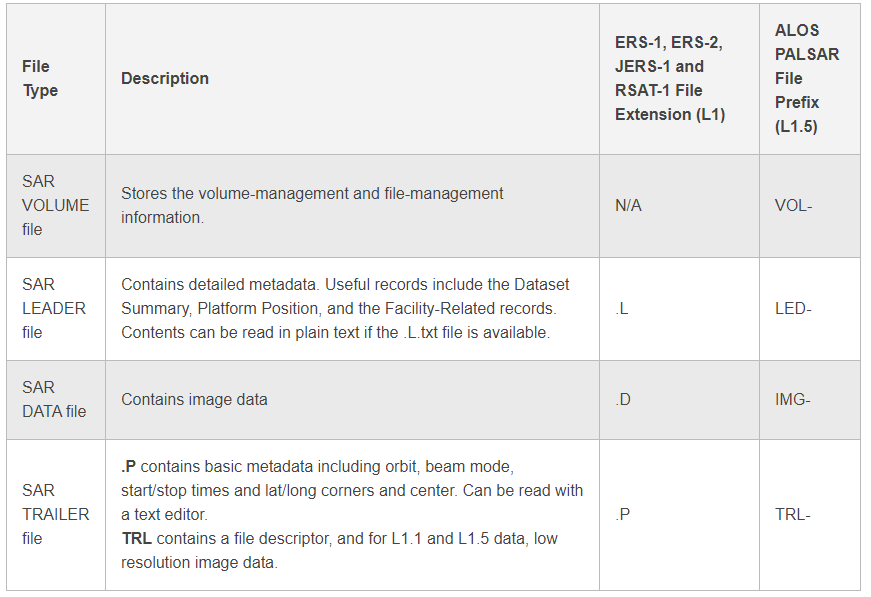

#2. Mount Google Drive

For this example, we will be storing our data within Google Drive. In [Exercise 1](https://), we stored our data in GitHub. In future, use the method that works best for you.

In order to access your Google Drive and all of the files stored within from the colab, you need to mount your drive. When you run the following code, you will be prompted to authorize your Google account. In this section, you are also creating a symbolic pathname "content/notebooks" that represents "content/mnt/My Drive/Colab Notebooks" to circumvent issues arising from the space in "My Drive."

In [0]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

#3. Prepare Data in Appropriate Directory


 During the ISCE installation, you created the following directory:
```
/content/notebooks/isce-notebook/isce-2.2.0/install/isce
```
Move the two SLC folders that you copied to your drive to this directory. In the next step, we will create an ISCE_HOME environment variable that will point to this directory, in addition to other environmental variables.

##3. Set Environment Variables

The following environment variables must be run before each session you plan to run ISCE.

In [0]:
import os
os.environ['ISCE_ROOT'] = "/content/notebooks/isce-notebook/isce-2.2.0/install"
os.environ['ISCE_HOME'] = "/content/notebooks/isce-notebook/isce-2.2.0/install/isce"
os.environ['PATH'] = "/content/notebooks/isce-notebook/isce-2.2.0/install/isce/bin:/content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications:/usr/bin/env:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin"
os.environ['PYTHONPATH']= "/content/notebooks/isce-notebook/isce-2.2.0/install:/content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications:/content/notebooks/isce-notebook/isce-2.2.0/install/isce/components"

##4.1 XML Overivew

The XML file tells ISCE where the input data files are and the name of the root folder they are stored in. Please see the overall file structure that we will use for this exercise below. The document opens and closes with `stripmapApp` header. The sensor name is a property that applies to both images, which are separate components named `Master` and `Slave`. For a full list of sensors that can be processed using `stripmapApp`, call `stripmapApp.py --help`. 

![alt text](https://drive.google.com/uc?id=1GpQGs9i8b2kHZJs5Jfm2jM_Eo5HZgmw8)

Now let's take a look at image 1, or the `Master `component. This component includes two properties, one is the image file and one is the leader (or metadata file). In this case, these files are from the ALOS PALSAR data used for this exercise from July 10, 2007 (Image 2 is October 10, 2007). The property names `IMAGEFILE` and `LEADER` refer to the CEOS file type required for this preprocessing step. These property names will remain static. However, notice the directories that point to where these files sit in your Google Drive. We have placed our data within our `ISCE_HOME/application directory as the XML file below shows, but in future when using your own data you will have to edit the name of your files.

![alt text](https://drive.google.com/uc?id=1Ty-zrSmVUrm5M2VMfwxTI_Rp7WawQgxy)

#4.2 Interpreting ALOS PALSAR File Name

![alt text](https://drive.google.com/uc?id=1cvo_Q_lRH9fS_pdoo9c-7Bj8KJwT4o3v)

[Figure Source.](https://github.com/isce-framework/isce2-docs/blob/master/tutorial/Lab3_1ProcessingALOSPALSAR.pdf)

##4.2 Create XML File

Let's navigate to ISCE_HOME, which is an environmental variable we defined in step 4. This is where we want to create our XML file. 

In [0]:
%cd /content/notebooks/isce-notebook/isce-2.2.0/install/isce

Now we will create the XML file within the ISCE_HOME directory. In future, you can edit the properties to fit your data. For this exercise, no changes should be necessary.

In [0]:
from google.colab import files

with open('stripmapApp.xml', 'w') as f:
  f.write("""
<stripmapApp>
<component name="insar">
<property name="sensor name">ALOS_SLC</property>
    <component name="Master">
        <property name="IMAGEFILE">
           /content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications/SLC_07102007/IMG-HV-ALPSRP077610890-H1.1__A
        </property>
        <property name="LEADERFILE">
           /content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications/SLC_07102007/LED-ALPSRP077610890-H1.1__A
        </property>
        <property name="OUTPUT">07102007</property>
    </component>
    <component name="Slave">
        <property name="IMAGEFILE">
            /content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications/SLC_10102007/IMG-HV-ALPSRP091030890-H1.1__A
        </property>
        <property name="LEADERFILE">
            /content/notebooks/isce-notebook/isce-2.2.0/install/isce/applications/SLC_10102007/LED-ALPSRP091030890-H1.1__A
        </property>
        <property name="OUTPUT">10102007</property>
    </component>
</component>
</stripmapApp>""")

List directory contents to see that the `stripmapApp.xml` was created. 

In [0]:
ls -a

##5. Provide EarthData Credentials

ISCE automatically retrieves the Digital Elevation Model from [EarthData](https://earthdata.nasa.gov/) when necessary for preprocessing. In addition to have login information, please** add LPDAAC applications to your account.** Login to [EarthData](https://urs.earthdata.nasa.gov/home), click on "my applications" in the profile, choose “Add More Applications,” search for “LP DAAC,” select “LP DAAC Data Pool” and “LP DAAC OpenDAP,” and approve.

You need to provide your personal credentials for ISCE to use to sign in on your behalf. To do this, we will create a .netrc in the ISCE_HOME directory: `/content/mnt/My Drive/Colab Notebooks/isce-notebook/isce-2.2.0/install/isce`. Use the pwd below to make sure that you are there.

In [0]:
!pwd

In [0]:
!cp .netrc /content/
!cp .netrc /root/

NOTE: I'm currently bringing the .netrc directly into my google drive after editing on my computer. 

**You will have to edit the code below.** Update `yourusername` to your personal username, e.g. `JohnSmith`, and `yourpassword` to your personal password, e.g. `Pass123!`.

In [0]:
from google.colab import files

with open('.netrc', 'w') as f:
  f.write("""
machine urs.earthdata.nasa.gov
    login yourusername
    password yourpassword

  """)

#6. Install all dependencies


The following dependencies must be installed before each session where you are using ISCE.

In [0]:
!apt update
!apt install -y gfortran libmotif-dev libhdf5-dev libfftw3-dev libgdal-dev scons python3 cython3 python3-scipy python3-matplotlib python3-h5py python3-gdal python3-pip

In [0]:
!echo $PATH

In [0]:
!touch /content/path_test.py

In [0]:
with open('/content/path_test.py','w') as f:
  f.writelines("""
import os, sys
print(os.getcwd())
print(os.environ)
  """)

In [0]:
!python3 /content/path_test.py

In [0]:
!ls -a /root/

##Test ISCE Installation

In [0]:
!python3 $ISCE_HOME/applications/stripmapApp.py --help

##Run ISCE



For this exercise, we will be using `stripmapApp.py `to create interferograms from Single Look Complex (SLC) scenes from ALOS PALSAR and the `stripmapApp.xml` that we created in step 4. Let's run ISCE!

In [0]:
!python3 $ISCE_HOME/applications/stripmapApp.py $ISCE_HOME/stripmapApp.xml

In [0]:
!grep -r stripmapApp.xml

In [0]:
with open('/stripmapApp.xml','r') as f:
  print(f.readlines())

After running the code block above, you should see...